<h1><center>Quora question pair similarity</center></h1>

<h1> 1) Data Overview</h1>

<p> The dataset contains information on the question pairs from quora and their similarity classifications. The dataset contains 404k question pairs in rows and 6 columns. Below are the list of columns  and their descriptions:</p>
    <ul>
    <li>id - the id of a training set question pair</li>
    <li>qid1, qid2 - unique ids of each question</li>
    <li>question1, question2 - the full text of each question</li>
    <li>is_duplicate - 1 if question1 and question2 are the same, and 0 otherwise.</li></ul>
    
<h2>Objective:</h2>
<p>To predict if a given pair of questions have the same meaning or not.</p>


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os

import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from fuzzywuzzy import fuzz
import distance

warnings.filterwarnings("ignore")

import dill

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df=pd.read_csv('drive/My Drive/Colab Notebooks/train.csv')
print(df.shape)
print(df.columns)

(404290, 6)
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


<h1>2. Data preprocessing and Feature addition </h1>

### 2.1 Considering 100k datapoints

In [4]:
project_data_1=df[df['is_duplicate']==1]
project_data_0=df[df['is_duplicate']==0]

print(project_data_1.shape)
print(project_data_0.shape)

#Creating a dataset of 0.2k points containg points from both the classes
project_data = project_data_1[0:50000].append(project_data_0[0:50000])
print(project_data['is_duplicate'].value_counts())
print(project_data.shape)
print(project_data.info())

(149263, 6)
(255027, 6)
1    50000
0    50000
Name: is_duplicate, dtype: int64
(100000, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5 to 79686
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.3+ MB
None


### Observation:
- Considering 50k points from each class and storing in a single dataframe.
- The dataset is now balanced as it has equal number of datapoints from each class.

### 2.2 Checking for duplicates

In [5]:
#checking whether there are any repeated pair of questions

pair_duplicates = project_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - project_data.shape[0])

Number of duplicate questions 0


### 2.3 Checking for null values

In [6]:
#Checking whether there are any rows with null values
nan_rows = project_data[project_data.isnull().any(1)]
print (nan_rows)

# Filling null values with ' '
project_data = project_data.fillna('')
nan_rows = project_data[project_data.isnull().any(1)]
print (nan_rows.shape)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []
(0, 6)


### 2.4 Text Preprocessing

In [7]:
import nltk
nltk.download("stopwords")

# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.5 Basic feature extraction

<h4> Constructing the below features: </h4> 

- ____freq_qid1____ = Frequency of qid1's
- ____freq_qid2____ = Frequency of qid2's 
- ____q1len____ = Length of q1
- ____q2len____ = Length of q2
- ____q1_n_words____ = Number of words in Question 1
- ____q2_n_words____ = Number of words in Question 2
- ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
- ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
- ____word_share____ = (word_common)/(word_Total)
- ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
- ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [8]:
project_data['freq_qid1'] = project_data.groupby('qid1')['qid1'].transform('count') 
project_data['freq_qid2'] = project_data.groupby('qid2')['qid2'].transform('count')
project_data['q1len'] = project_data['question1'].str.len() 
project_data['q2len'] = project_data['question2'].str.len()
project_data['q1_n_words'] = project_data['question1'].apply(lambda row: len(row.split(" ")))
project_data['q2_n_words'] = project_data['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
project_data['word_Common'] = project_data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
project_data['word_Total'] = project_data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
project_data['word_share'] = project_data.apply(normalized_word_share, axis=1)

project_data['freq_q1+q2'] = project_data['freq_qid1']+project_data['freq_qid2']
project_data['freq_q1-q2'] = abs(project_data['freq_qid1']-project_data['freq_qid2'])

project_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,1,1,30,41,7,9,4.0,16.0,0.250000,2,0
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1,1,1,43,38,9,8,5.0,17.0,0.294118,2,0
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1,1,2,36,39,7,8,6.0,15.0,0.400000,3,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1,1,2,43,38,7,6,5.0,13.0,0.384615,3,1


### 2.6 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

    Token: You get a token by splitting sentence a space
    Stop_Word : stop words as per NLTK.
    Word : A token that is not a stop_word

Features:

    cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


    cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


    csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


    csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


    ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


    ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
    ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


    last_word_eq : Check if First word of both questions is equal or not
    last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


    first_word_eq : Check if First word of both questions is equal or not
    first_word_eq = int(q1_tokens[0] == q2_tokens[0])


    abs_len_diff : Abs. length difference
    abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


    mean_len : Average Token Length of both Questions
    mean_len = (len(q1_tokens) + len(q2_tokens))/2

    longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
    longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(project_data):
    # preprocessing each question
    project_data["question1"] = project_data["question1"].fillna("").apply(preprocess)
    project_data["question2"] = project_data["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = project_data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    project_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    project_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    project_data["csc_min"]       = list(map(lambda x: x[2], token_features))
    project_data["csc_max"]       = list(map(lambda x: x[3], token_features))
    project_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    project_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    project_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    project_data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    project_data["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    project_data["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    project_data["token_set_ratio"]       = project_data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    project_data["token_sort_ratio"]      = project_data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    project_data["fuzz_ratio"]            = project_data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    project_data["fuzz_partial_ratio"]    = project_data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    project_data["longest_substr_ratio"]  = project_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return project_data

In [10]:
project_data = extract_features(project_data)
project_data.head(2)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,81,77,73,73,0.160920
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,1,1,30,41,7,9,4.0,16.0,0.250000,2,0,0.499975,0.499975,0.599988,0.428565,0.571420,0.444440,1.0,0.0,2.0,8.0,71,61,61,67,0.354839


In [11]:
print(project_data.shape)
print(project_data.info())

(100000, 32)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5 to 79686
Data columns (total 32 columns):
id                      100000 non-null int64
qid1                    100000 non-null int64
qid2                    100000 non-null int64
question1               100000 non-null object
question2               100000 non-null object
is_duplicate            100000 non-null int64
freq_qid1               100000 non-null int64
freq_qid2               100000 non-null int64
q1len                   100000 non-null int64
q2len                   100000 non-null int64
q1_n_words              100000 non-null int64
q2_n_words              100000 non-null int64
word_Common             100000 non-null float64
word_Total              100000 non-null float64
word_share              100000 non-null float64
freq_q1+q2              100000 non-null int64
freq_q1-q2              100000 non-null int64
cwc_min                 100000 non-null float64
cwc_max                 100000 non-null

### 2.7 Splitting data into train and test (70:30)

In [12]:
df_train, df_test = train_test_split(project_data, test_size = 0.3, stratify=project_data['is_duplicate'])
print(df_train.shape,df_test.shape)

(70000, 32) (30000, 32)


In [13]:
y_train=df_train['is_duplicate']
y_test=df_test['is_duplicate']

print(len(y_train),len(y_test))

70000 30000


<h1> 3. Make Data Model Ready </h1>

### 3.1 Vectorizing Q1 and Q2 using TFIDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)

q1_train_tfidf = vectorizer.fit_transform(df_train['question1'])
q1_test_tfidf = vectorizer.transform(df_test['question1'])
print("Shape of matrix after one hot encoding (q1 train, test)",q1_train_tfidf.shape, q1_test_tfidf.shape)

q2_train_tfidf = vectorizer.fit_transform(df_train['question2'])
q2_test_tfidf = vectorizer.transform(df_test['question2'])
print("Shape of matrix after one hot encoding (q2 train, test)",q2_train_tfidf.shape, q2_test_tfidf.shape)
print(type(q2_train_tfidf),q2_train_tfidf.shape,type(df_train))

Shape of matrix after one hot encoding (q1 train, test) (70000, 5024) (30000, 5024)
Shape of matrix after one hot encoding (q2 train, test) (70000, 4955) (30000, 4955)
<class 'scipy.sparse.csr.csr_matrix'> (70000, 4955) <class 'pandas.core.frame.DataFrame'>


### 3.2 Removing ID, Q1 and Q2 columns from dataframe

In [15]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
29705,29705,54932,54933,does palestine have an army are they fighting...,why does not palestine have an army,0,1,1,52,35,9,6,4.0,15.0,0.266667,2,0,0.999950,0.499988,0.599988,0.599988,0.714276,0.555549,0.0,0.0,2.0,8.0,87,73,63,78,0.648649
100145,100145,166160,166161,how can i record sound from headphones,how would i directly record the sound from my ...,1,1,1,39,57,7,10,6.0,17.0,0.352941,2,0,0.999967,0.599988,0.749981,0.599988,0.857131,0.599994,1.0,1.0,3.0,8.5,94,77,74,77,0.300000
28115,28115,52159,52160,why is windows 10 so buggy,is windows 10 buggy,1,1,1,27,20,6,4,4.0,10.0,0.400000,2,0,0.999967,0.999967,0.999900,0.333322,0.999975,0.666656,1.0,0.0,2.0,5.0,100,84,84,85,0.666667
30376,30376,56113,56114,why does cubic have a monopoly on transit agen...,how competitive is the hiring process at cubic,0,1,1,60,47,10,8,0.0,18.0,0.000000,2,0,0.249994,0.199996,0.000000,0.000000,0.124998,0.099999,0.0,0.0,2.0,9.0,32,30,23,23,0.145833
40246,40246,72839,72840,would you buy the apple watch,should i buy an apple watch,0,1,1,30,28,6,6,3.0,12.0,0.250000,2,0,0.999967,0.749981,0.000000,0.000000,0.499992,0.499992,1.0,0.0,0.0,6.0,75,61,79,79,0.448276


In [16]:
df_train.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1, inplace=True)
df_test.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1, inplace=True)

print(df_train.shape, df_test.shape)

(70000, 26) (30000, 26)


<h1> 4. Training various models on TFIDF featurization </h1>

### 4.1 Logistic Regression

In [17]:
#https://www.digitalocean.com/community/tutorials/how-to-plot-data-in-python-3-using-matplotlib
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    
from scipy.sparse import hstack
from sklearn import linear_model
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score

print(type(q1_train_tfidf), type(q2_train_tfidf))

x_train = hstack((df_train,q1_train_tfidf, q2_train_tfidf))

x_test = hstack((df_test,q1_test_tfidf, q2_test_tfidf))

print(x_train.shape, type(x_train), y_train.shape, type(y_train))
print(x_test.shape, type(x_test), y_test.shape, type(y_test))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
(70000, 10005) <class 'scipy.sparse.coo.coo_matrix'> (70000,) <class 'pandas.core.series.Series'>
(30000, 10005) <class 'scipy.sparse.coo.coo_matrix'> (30000,) <class 'pandas.core.series.Series'>


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

 14%|█▍        | 1/7 [00:46<04:41, 46.92s/it]

For values of alpha =  1e-05 The log loss is: 0.443534214713942


 29%|██▊       | 2/7 [01:34<03:55, 47.06s/it]

For values of alpha =  0.0001 The log loss is: 0.4355493161781906


 43%|████▎     | 3/7 [02:00<02:42, 40.72s/it]

For values of alpha =  0.001 The log loss is: 0.44742460814014956


 57%|█████▋    | 4/7 [02:10<01:34, 31.49s/it]

For values of alpha =  0.01 The log loss is: 0.4781831470217574


 71%|███████▏  | 5/7 [02:13<00:46, 23.18s/it]

For values of alpha =  0.1 The log loss is: 0.5036653100098649


 86%|████████▌ | 6/7 [02:16<00:16, 16.86s/it]

For values of alpha =  1 The log loss is: 0.5306021130995565


100%|██████████| 7/7 [02:17<00:00, 12.27s/it]

For values of alpha =  10 The log loss is: 0.5806464946361329


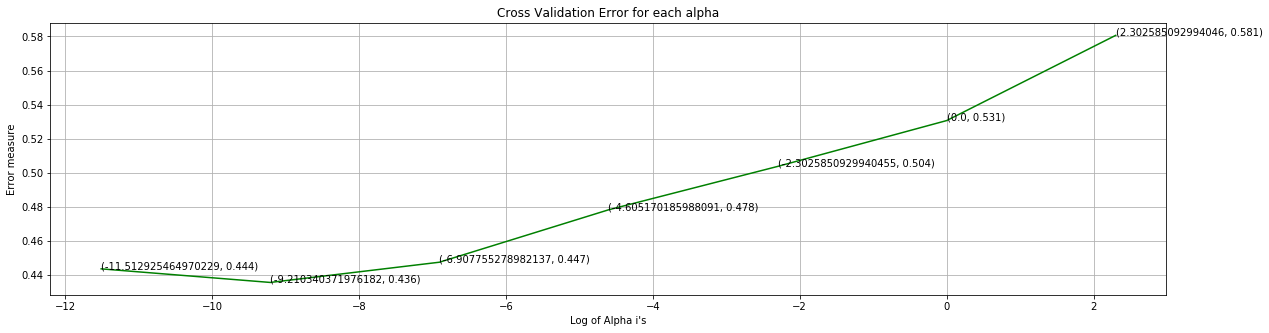

For values of best alpha =  0.0001 The train log loss is: 0.43269034898107744
For values of best alpha =  0.0001 The test log loss is: 0.4355493161781906
Total number of data points : 30000


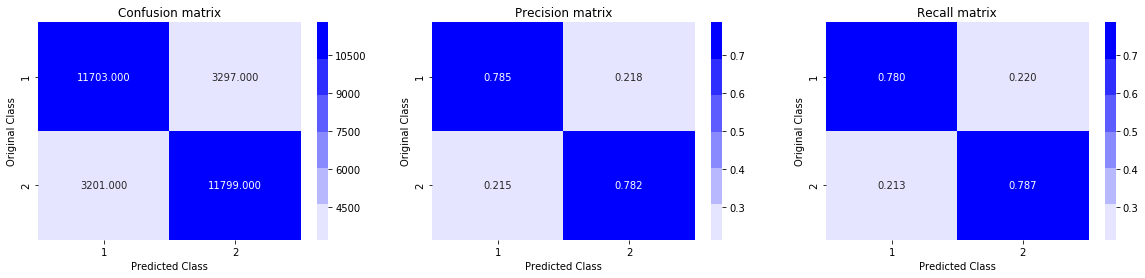

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

from tqdm import tqdm

log_params = []
for i in alpha:
    log_params.append(math.log(i))

log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(log_params, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((log_params[i],np.round(txt,3)), (log_params[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log of Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
import dill
#dill.dump_session("drive/My Drive/Colab Notebooks/quora_sess.pckl")
dill.load_session("drive/My Drive/Colab Notebooks/quora_sess.pckl")

### 4.2 Linear SVM

In [0]:
#https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution

#As MinMaxscaler and StandardScaler doesnot support sparse matrices, we are using MaxAbsScaler

from sklearn.preprocessing import MaxAbsScaler

scaling = MaxAbsScaler().fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [3]:
C = [10 ** x for x in range(-4, 2)] # hyperparam for Linear SVM.

import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

from sklearn.svm import SVC

log_params = []
for i in C:
    log_params.append(math.log(i))

log_error_array=[]
for i in C:
    clf = SVC(kernel='linear', C=i, max_iter=3000)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of C = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of C =  0.0001 The log loss is: 9.00092099018136
For values of C =  0.001 The log loss is: 8.916874688599997
For values of C =  0.01 The log loss is: 8.30322227477376
For values of C =  0.1 The log loss is: 8.203055718628379
For values of C =  1 The log loss is: 8.76143745457051
For values of C =  10 The log loss is: 9.07920552503395


6 6
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046]


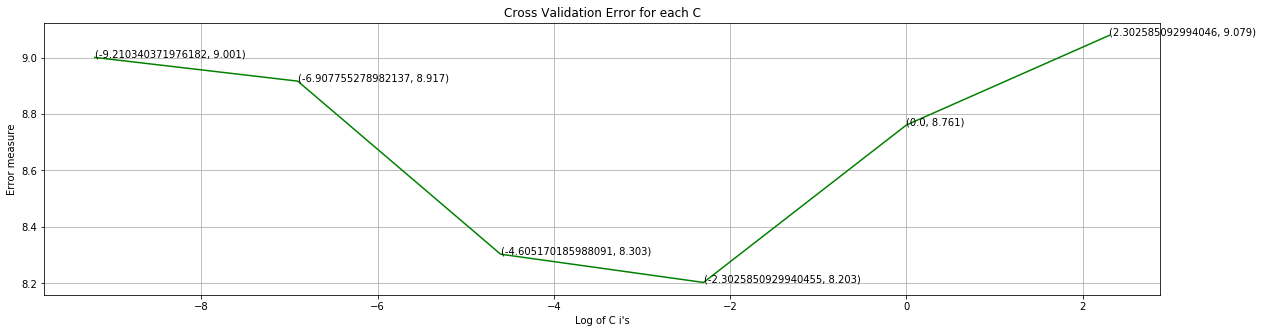

For values of best C =  0.1 The train log loss is: 0.46789232139633063
For values of best C =  0.1 The test log loss is: 0.47991953410792887
Total number of data points : 30000


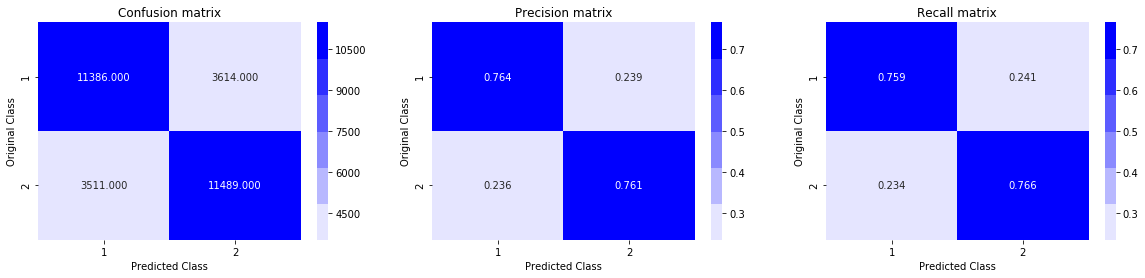

In [4]:
print(len(log_error_array), len(log_params))

print(log_params)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(log_params, log_error_array, c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((log_params[i],np.round(txt,3)), (log_params[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("Log of C i's")
plt.ylabel("Error measure")
plt.show()

best_C = np.argmin(log_error_array)
clf = SVC(C=C[best_C], kernel='linear', max_iter=3000)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 4.3 XGBoost using RandomSearch

In [11]:
#https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

#Initialising Classifier
classifier = xgb.XGBClassifier()

alpha_range= np.arange(5,500)
parameters = {'n_estimators':alpha_range}
#parameters = dict(n_neighbors=knn_range)

#Training the model on train data
XGB_tfidf = RandomizedSearchCV(classifier, parameters, n_iter=3, cv=3, scoring='neg_log_loss', n_jobs=-1, return_train_score=True)
XGB_tfidf.fit(x_train, y_train)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
       460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
      

{'n_estimators': 376}
{'mean_fit_time': array([101.88425914,  34.44643203,   5.29446936]), 'std_fit_time': array([0.81996803, 0.23335955, 0.04329103]), 'mean_score_time': array([0.84024175, 0.62163671, 0.54882272]), 'std_score_time': array([0.02134507, 0.00439325, 0.00744455]), 'param_n_estimators': masked_array(data=[376, 121, 14],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 376}, {'n_estimators': 121}, {'n_estimators': 14}], 'split0_test_score': array([-0.37318147, -0.39065504, -0.48167951]), 'split1_test_score': array([-0.36768504, -0.3848574 , -0.47928289]), 'split2_test_score': array([-0.37063197, -0.38755171, -0.47910127]), 'mean_test_score': array([-0.37049949, -0.38768805, -0.48002125]), 'std_test_score': array([0.00224589, 0.00236887, 0.00117493]), 'rank_test_score': array([1, 2, 3], dtype=int32), 'split0_train_score': array([-0.34638554, -0.37839963, -0.47766736]), 'split1_train_score': array([-0.34845

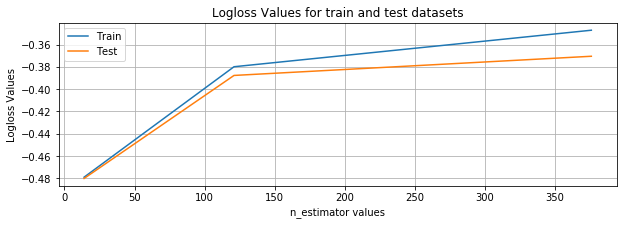

In [22]:
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

print(XGB_tfidf.best_params_) #Gives the best value of K from the given neighbor range
print(XGB_tfidf.cv_results_, XGB_tfidf.cv_results_['mean_test_score'])

params=[]

for i in (XGB_tfidf.cv_results_['params'][0:3]):
     params.append(i['n_estimators'])
'''
results=pd.DataFrame({'n_est':params,'mean_tr':GBDT_tfidf.cv_results_['mean_train_score'],'mean_te':GBDT_tfidf.cv_results_['mean_test_score']})

print(results)
'''
plt.figure(figsize=(10,3))
plt.plot(params,XGB_tfidf.cv_results_['mean_train_score'], label="Train")
plt.plot(params,XGB_tfidf.cv_results_['mean_test_score'], label="Test")
plt.title('Logloss Values for train and test datasets')
plt.xlabel('n_estimator values')
plt.ylabel('Logloss Values')
plt.legend()
plt.grid()
plt.show()
plt.close()

For values of best n =  376 The train log loss is: 0.35345983628039374
For values of best n =  376 The test log loss is: 0.36597825976484516
Total number of data points : 30000


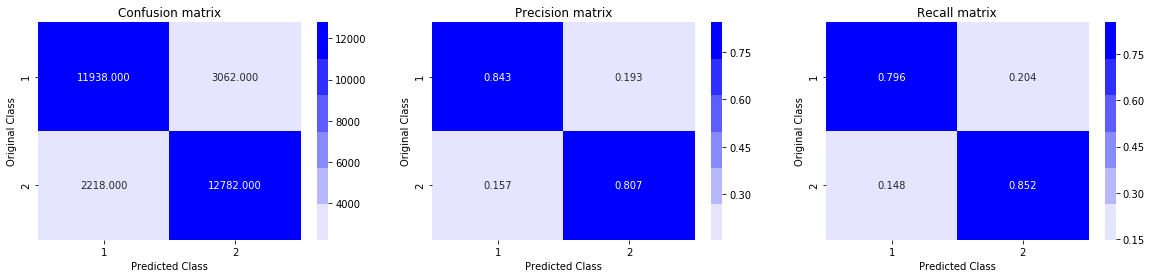

In [21]:
warnings.filterwarnings("ignore")

best_n = XGB_tfidf.best_params_['n_estimators']
clf = xgb.XGBClassifier(n_estimators=376)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=5)
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best n = ', best_n, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best n = ', best_n, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5. Conclusions

In [24]:
#http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "ML Model", "Best Hyper parameter", "Logloss(Train)", "Logloss(Test)"]

x.add_row(["TFIDF", "Logistic Regression", "alpha=0.0001", 0.432,0.435])
x.add_row(["TFIDF", "Linear SVM", "C=0.1", 0.467,0.479])
x.add_row(["TFIDF", "XGBoost(Random Search)", "n_estimators=376", 0.353,0.365])

print(x)

+------------+------------------------+----------------------+----------------+---------------+
| Vectorizer |        ML Model        | Best Hyper parameter | Logloss(Train) | Logloss(Test) |
+------------+------------------------+----------------------+----------------+---------------+
|   TFIDF    |  Logistic Regression   |     alpha=0.0001     |     0.432      |     0.435     |
|   TFIDF    |       Linear SVM       |        C=0.1         |     0.467      |     0.479     |
|   TFIDF    | XGBoost(Random Search) |   n_estimators=376   |     0.353      |     0.365     |
+------------+------------------------+----------------------+----------------+---------------+


**Observation:**
- XGBoost using Random Search has provided the minimum log loss both on test and train datasets.
- The train and test times for XGBoost were significantly lower than Linear SVM.

**Implementation Steps :**

1. Considered a total of 100k datapoints from the dataset, 50k from each class.
2. Preprocessing steps:
  *   Checked for any duplicate records based on question IDs
  *   Checked for 'nan' values and replaced them with nulls
  *   Expanded contracted words (Eg., Don't, Can't etc.,)
3. Added basic and advanced features to the dataframe.
4. Split the dataset in 70:30 ratio for train and test sets respectively.
5. Vectorized questions 1 and 2 columns with TFIDF vetorizer.
6. Logistic Regression:
  * Trained SGD Classifier with log loss and l2 regularizer for various values of alpha(Hyperparameter)
  * Log loss is captured for each value of alpha by comparing probabilities of train and test points
  * The alpha with minimum log loss is taken and applied to train and test data
  * Confusion, Precision and Recall matrices are plotted with the best alpha value
7. Linear SVM:
  *  Trained SVC Classifier with linear kernel for various values of C(Hyperparameter)
  * Log loss is captured for each value of C by comparing probabilities of train and test points
  * The C with minimum log loss is taken and applied to train and test data
  * Confusion, Precision and Recall matrices are plotted with the best C value
8. XGBoost:
  * Trained XGBoost classifier using RandomizedSearch  for different values of 'n_estimators'.
  * RandomSearch has 'neg_log_loss' instead of 'log_loss', so greater the value, better the performance
  * After finding the best parameter, the log loss values for the best paramater values are calculate using CalibratedClassifier.
  * Confusion, Precision and Recall matrices are plotted with the best 'n_estimator' value